<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# Automate Content Recommendation with Transformer Embeddings


Estimated time needed: **1** hour


# Table of contents

1. [Introduction](#Introduction)
2. [Objectives](#Objectives)
3. [Setup](#Setup)
   - [Installing required libraries](#Installing-Required-Libraries)
   - [Importing required libraries](#Importing-Required-Libraries)
4. [Step 1: Data loading and initial exploration](#Step-1:-Data-Loading-and-Initial-Exploration)
5. [Step 2: Generate text embeddings](#Step-2:-Generate-Text-Embeddings)
   - [Aggregating embeddings](#Aggregating-Embeddings)
7. [Step 3: Dimensionality reduction](#Step-3:-Dimensionality-Reduction)
8. [Step 4: Clustering](#Step-4:-Clustering)
   - [Determining the number of clusters](#Determining-the-Number-of-Clusters)
   - [K-means clustering](#K-means-Clustering)
   - [Advanced clustering with FAISS](#Advanced-Clustering-with-FAISS)
   - [Agglomerative clustering](#Agglomerative-Clustering)
   - [Evaluating clustering methods](#Evaluating-Clustering-Methods)
9. [Finding the best performing model](#Finding-the-Best-Perfoming-Model)
10. [Inference](#Inference)
11. [Exercise](#Exercise)


## Introduction

In this lab, you will explore how to leverage word embeddings for text segmentation, which is a process of grouping and categorizing textual data based on semantic similarity. Text segmentation is especially useful for tasks like organizing large datasets, discovering hidden themes in text, and building recommendation systems. By using word embeddings, we can transform text into numerical representations that capture semantic meaning, enabling more efficient clustering and analysis of the data.

This lab will guide you through several key stages, including generating embeddings with pre-trained transformer models, reducing the dimensionality of these embeddings, and clustering the data to identify meaningful segments. With the right techniques, this approach can provide valuable insights into the structure and content of a wide variety of text datasets.

## Objectives

After completing this lab, you will be able to:

- Use pre-trained transformer models to generate text embeddings.
- Apply dimensionality reduction techniques, such as PCA and UMAP, to high-dimensional text embeddings.
- Implement various clustering algorithms, including K-Means, FAISS, and Agglomerative Clustering, to categorize text data.
- Evaluate and compare the performance of different clustering methods using metrics like silhouette score.


----


## Setup


### Installing required libraries


Please be advised that the package installations may take between 5-10 minutes.


In [1]:
!pip install pandas torch transformers scikit-learn faiss-cpu matplotlib umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 117.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 380.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:0

In [2]:
!pip install --dry-run numba numpy

### Importing required libraries


In [3]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import faiss
import umap

import matplotlib.pyplot as plt
import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


If you get an error on this import block cell, you probably need to restart the kernel and re-run the above cell.


## Step 1: Data loading and initial exploration

First, we will load the dataset and perform some initial exploration to understand its structure and contents. The dataset includes 4,726 Courses and Guided Projects from [IBM Skills Network](https://cognitiveclass.ai/).


In [4]:
labs = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/AKmsNHd_-KnDvXWzNhaSrw/Labs.csv')
labs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4726 entries, 0 to 4725
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4726 non-null   int64  
 1   name               4726 non-null   object 
 2   short_description  4110 non-null   object 
 3   status             4726 non-null   object 
 4   rating             4726 non-null   float64
 5   tag                4726 non-null   object 
 6   created_at         4726 non-null   object 
 7   language           4726 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 295.5+ KB


In [5]:
labs.head(10)

,id,name,short_description,status,rating,tag,created_at,language
0,1577,eugene-tst-img-lib,NaN,Draft,0.0,JavaScript,2022-06-17 14:18:20 UTC,English
1,1466,Основи аналізу даних в банківській справі,Мета цієї лабораторної роботи – освоїти попере...,Published,4.9,Programming,2022-05-31 04:36:24 UTC,Ukrainian
2,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Data Science,2021-11-18 01:54:57 UTC,English
3,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Machine Learning,2021-11-18 01:54:57 UTC,English
4,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Unsupervised,2021-11-18 01:54:57 UTC,English
5,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Clustering,2021-11-18 01:54:57 UTC,English
6,1580,Egeria Dojo - Running Egeria,A hosted version of our Egeria Dojo - Day 1 \n...,Draft,0.0,Egeria,2022-06-20 15:50:00 UTC,English
7,1580,Egeria Dojo - Running Egeria,A hosted version of our Egeria Dojo - Day 1 \n...,Draft,0.0,Metadata,2022-06-20 15:50:00 UTC,English
8,1580,Egeria Dojo - Running Egeria,A hosted version of our Egeria Dojo - Day 1 \n...,Draft,0.0,Data Governance,2022-06-20 15:50:00 UTC,English
9,1580,Egeria Dojo - Running Egeria,A hosted version of our Egeria Dojo - Day 1 \n...,Draft,0.0,Kubernetes,2022-06-20 15:50:00 UTC,English


In [7]:
# select labs where status is published and language is English

selected_labs = labs[(labs['status'] == 'Published') & (labs['language'] =='English')]
selected_labs


,id,name,short_description,status,rating,tag,created_at,language
2,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Data Science,2021-11-18 01:54:57 UTC,English
3,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Machine Learning,2021-11-18 01:54:57 UTC,English
4,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Unsupervised,2021-11-18 01:54:57 UTC,English
5,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Clustering,2021-11-18 01:54:57 UTC,English
10,998,Retail: Data Preparation and Basic Statistica...,"This lab is dedicated to downloading, preparin...",Published,5.0,Machine Learning,2021-12-27 07:42:45 UTC,English
...,...,...,...,...,...,...,...,...
4613,1381,Scan an Image for Vulnerabilities and Configur...,Deploying container images with security vulne...,Published,4.8,IdP,2022-05-10 22:02:05 UTC,English
4614,523,Advanced Machine & Deep Learning for SPAM clas...,Learn to build the Machine &amp; Deep Learning...,Published,4.6,Information Technology,2021-07-05 10:14:05 UTC,English
4625,1417,Market Basket Analysis for Marketing,This lab is dedicated to performing the market...,Published,4.5,Application Development,2022-05-23 05:23:53 UTC,English
4626,1417,Market Basket Analysis for Marketing,This lab is dedicated to performing the market...,Published,4.5,CI/CD,2022-05-23 05:23:53 UTC,English


In [8]:
# concatenate short_description and title into a single column

selected_labs['description'] = selected_labs['name'] + ' ' + selected_labs['short_description']
selected_labs


,id,name,short_description,status,rating,tag,created_at,language,description
2,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Data Science,2021-11-18 01:54:57 UTC,English,Performing Database Operations in the Cloudant...
3,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Machine Learning,2021-11-18 01:54:57 UTC,English,Performing Database Operations in the Cloudant...
4,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Unsupervised,2021-11-18 01:54:57 UTC,English,Performing Database Operations in the Cloudant...
5,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Clustering,2021-11-18 01:54:57 UTC,English,Performing Database Operations in the Cloudant...
10,998,Retail: Data Preparation and Basic Statistica...,"This lab is dedicated to downloading, preparin...",Published,5.0,Machine Learning,2021-12-27 07:42:45 UTC,English,Retail: Data Preparation and Basic Statistica...
...,...,...,...,...,...,...,...,...,...
4613,1381,Scan an Image for Vulnerabilities and Configur...,Deploying container images with security vulne...,Published,4.8,IdP,2022-05-10 22:02:05 UTC,English,Scan an Image for Vulnerabilities and Configur...
4614,523,Advanced Machine & Deep Learning for SPAM clas...,Learn to build the Machine &amp; Deep Learning...,Published,4.6,Information Technology,2021-07-05 10:14:05 UTC,English,Advanced Machine & Deep Learning for SPAM clas...
4625,1417,Market Basket Analysis for Marketing,This lab is dedicated to performing the market...,Published,4.5,Application Development,2022-05-23 05:23:53 UTC,English,Market Basket Analysis for Marketing This lab ...
4626,1417,Market Basket Analysis for Marketing,This lab is dedicated to performing the market...,Published,4.5,CI/CD,2022-05-23 05:23:53 UTC,English,Market Basket Analysis for Marketing This lab ...


In [9]:
# select unique id,description

unique_labs = selected_labs[['id', 'description']].drop_duplicates()
unique_labs


,id,description
2,868,Performing Database Operations in the Cloudant...
10,998,Retail: Data Preparation and Basic Statistica...
11,1014,Market Basket Analysis Market basket analysis ...
13,678,Client behavior classification in Banking The ...
16,1417,Market Basket Analysis for Marketing This lab ...
...,...,...
4439,6854,RAG with LlamaIndex: Build a retrieval agent u...
4462,6859,Fine-Tuning BERT for Text Reconstruction with ...
4583,6864,Master How To Load Documents Across Formats wi...
4586,6868,Build a Smarter Search with LangChain Context ...


In [10]:
descriptions = unique_labs['description'].tolist()

In [11]:
#check statistics about length of text in descprition column
max_length = max(len(str(desc)) for desc in descriptions)
min_length = min(len(str(desc)) for desc in descriptions)
avg_length = sum(len(str(desc)) for desc in descriptions) / len(descriptions)

print(f"Maximum length: {max_length}")
print(f"Minimum length: {min_length}")
print(f"Average length: {avg_length}")

Maximum length: 658
Minimum length: 3
Average length: 371.2625


## Step 2: Generate text embeddings

Next, you will use a pre-trained transformer model to generate text embeddings for each description. This will help in clustering similar descriptions together.
You will need to create the Transformer model as well as its associated tokenizer. The tokenizer will take of breaking the input text (content descriptions) into separate tokens and convert tokens to token IDs. The Transformer model is then used to convert token IDs to embedding vectors.


In [12]:
Model = 'MiniLM'
# Choose a transformer model; 'bert-base-uncased' is a good starting point
model_name = 'bert-base-uncased' if Model=='BERT' else 'roberta-base' if Model=='RoBERTa' else 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()  # Set model to evaluation mode

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


### Aggregating embeddings

There are two approaches to convert each description to a vector:

- Extracting the embedding vector of the `[CLS]` token. Classification token (`[CLS]`) is a special token used in Transformer architecture. It is a token that represents the entire input sequence or sentence and is placed at the beginning of the input.
- Averaging all token embeddings in a sequence (description).


In [13]:
def CLS_embeddings(text_list, tokenizer, model, device, batch_size=1):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_text = text_list[i:i+batch_size]
            # Ensure all elements in batch_text are strings
            batch_text = [str(text) for text in batch_text]  # Convert to strings
            encoded_input = tokenizer(batch_text, padding=True, truncation=True, return_tensors='pt', max_length=512)
            input_ids = encoded_input['input_ids'].to(device)
            attention_mask = encoded_input['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Get the [CLS] token embedding
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)
            embeddings.append(cls_embeddings.cpu())

    # Concatenate all batches
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings


In [14]:
def get_mean_pooling_embeddings(text_list, tokenizer, model, device, batch_size=1):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_text = text_list[i:i+batch_size]
            batch_text = [str(text) for text in batch_text]
            encoded_input = tokenizer(batch_text, padding=True, truncation=True, return_tensors='pt', max_length=512)
            input_ids = encoded_input['input_ids'].to(device)
            attention_mask = encoded_input['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Mean Pooling: Take the average of all token embeddings, ignoring padding tokens
            token_embeddings = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
            mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            mean_pooled_embeddings = sum_embeddings / sum_mask
            embeddings.append(mean_pooled_embeddings.cpu())

    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

In [15]:
# select CLS or MEAN pooling
AGG = 'CLS'
get_embeddings = get_mean_pooling_embeddings if AGG == 'MEAN' else CLS_embeddings
# Generate embeddings
embeddings = get_embeddings(descriptions, tokenizer, model, device)
print(f'Embeddings shape: {embeddings.shape}')  # Should be (num_courses, hidden_size)

Embeddings shape: torch.Size([240, 384])


## Step 3: Dimensionality reduction

Here, we'll apply PCA and UMAP to reduce the dimensionality of the embeddings, which helps in visualizing and clustering the data.


In [16]:
# Standardize the embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Apply PCA
#pca = PCA(n_components=.95)  # Keep components explaining 95% of variance
pca = PCA(n_components=5) # keep exact 5 most important components

embeddings_pca = pca.fit_transform(embeddings_scaled)





### Analyze the scatter coefficients

You can now examine the correlation between the original embeddings and those derived from dimensionality reduction:


In [17]:
# Calculate Spearman correlation between original embeddings and PCA embeddings
correlation_matrix = spearmanr(embeddings_scaled, embeddings_pca).correlation

correlation_matrix

array([[ 1.        ,  0.01747644, -0.02350085, ...,  0.20700151,
         0.11397902,  0.0043243 ],
       [ 0.01747644,  1.        ,  0.05916989, ..., -0.00526876,
         0.36420049,  0.10270191],
       [-0.02350085,  0.05916989,  1.        , ...,  0.01206662,
        -0.1555466 ,  0.07649398],
       ...,
       [ 0.20700151, -0.00526876,  0.01206662, ...,  1.        ,
         0.03586566, -0.05669936],
       [ 0.11397902,  0.36420049, -0.1555466 , ...,  0.03586566,
         1.        , -0.0025977 ],
       [ 0.0043243 ,  0.10270191,  0.07649398, ..., -0.05669936,
        -0.0025977 ,  1.        ]])

The diagonal of the resulting matrix approaches 1 that signifies that each variable is perfectly correlated with itself, while the off-diagonal elements vary between -1 and 1 indicating how much the original scaled embeddings (embeddings_scaled) and the embeddings obtained after applying PCA (embeddings_pca) are correlated.


You can also calculate the scatter coefficient that gives insight into how well each principal component captures the variance from the original data, with a higher value indicating better retention of variance.


In [18]:
# Calculate the scatter coefficient for each principal component
scatter_coefficients = []
for i in range(embeddings_pca.shape[1]):
  scatter_coefficient = np.var(embeddings_pca[:,i]) / np.var(embeddings_scaled[:,i])
  scatter_coefficients.append(scatter_coefficient)

print("Scatter Coefficients for each principal component:", scatter_coefficients)

Scatter Coefficients for each principal component: [np.float64(21.377123734694695), np.float64(18.736389535747357), np.float64(16.29119427518216), np.float64(14.493525463567842), np.float64(10.508651726521512)]


You can also look at the explained variance ratio to understand how much variance is explained by each principal component:


In [19]:

print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Explained Variance Ratio: [0.05566959 0.04879268 0.04242499 0.03774356 0.02736628]


### UMAP for dimensionality reduction

Considering UMAP (Uniform Manifold Approximation and Projection) as an alternative to PSA (Principal Component Analysis) can be beneficial for several reasons:

- **Non-linear dimensionality reduction**: UMAP is capable of capturing non-linear relationships in the data, which can be advantageous when the underlying structure is complex and not well-represented by linear methods like PCA.
- **Preservation of local structure**: UMAP focuses on preserving the local structure of the data, which can result in more meaningful visualizations, especially when the goal is to understand local clusters or groupings.
- **Flexibility**: UMAP has parameters that allow you to adjust the balance between local and global structure preservation, offering more flexibility to tailor the dimensionality reduction to specific needs.
- **Speed and scalability**: UMAP is often faster than other non-linear dimensionality reduction techniques like t-SNE, making it suitable for large datasets.
- **Better visualizations**: UMAP can produce clearer and more interpretable two-dimensional visualizations, which are often used for exploratory data analysis.

Overall, UMAP is a powerful tool for visualization and understanding complex datasets, particularly when the data has non-linear structures that are not well captured by PCA.


In [20]:
# use umap instead of pca

# Standardize the embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)


# Apply UMAP
#reducer = umap.UMAP(n_components=5, random_state=42)
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2)
embeddings_umap = reducer.fit_transform(embeddings_scaled)


# Calculate Spearman correlation between original embeddings and UMAP embeddings
correlation_matrix = spearmanr(embeddings_scaled, embeddings_umap).correlation

# You can also analyze the UMAP embeddings in a similar way to PCA embeddings.

# Calculate the scatter coefficient for each principal component
scatter_coefficients = []
for i in range(embeddings_umap.shape[1]):
  scatter_coefficient = np.var(embeddings_umap[:,i]) / np.var(embeddings_scaled[:,i])
  scatter_coefficients.append(scatter_coefficient)

print("Scatter Coefficients for each principal component:", scatter_coefficients)


Scatter Coefficients for each principal component: [np.float64(3.0874135494232195), np.float64(1.7913495302200322)]


In [21]:
# Select DR method
PCA = False
embeddings_reduced = embeddings_pca if PCA else embeddings_umap

In [22]:
# normalize embeddings_reduced

embeddings_reduced = normalize(embeddings_reduced)


## Step 4: Clustering


## Determining the number of clusters


This code defines a function, plot_elbow, that helps determine the optimal number of clusters, k, for K-Means clustering by using the “elbow method.” The elbow method is a graphical approach that plots the inertia (also known as distortion or within-cluster sum of squares) as a function of the number of clusters, k. Domain knowledge can also help to identify a good value for k.


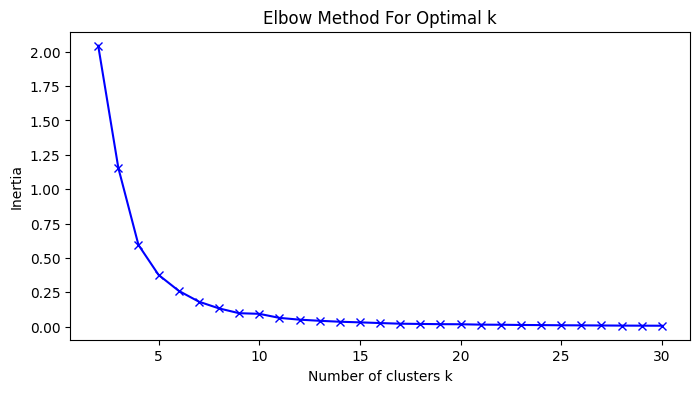

In [23]:
def plot_elbow(embeddings, max_k=10):
    distortions = []
    K = range(2, max_k+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8,4))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# Plot the elbow
plot_elbow(embeddings_reduced, max_k=30)

As the elbow plot shows, inertia decreases as k increases. However, around k=15, the rate of decrease slows significantly, making k=15 a reasonable choice for the number of clusters.


### K-means clustering


In [31]:
# Using Scikit-learn's KMeans
k = 15  # Replace with your chosen number of clusters
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
unique_labs['KMeans_cluster'] = kmeans.fit_predict(embeddings_reduced)

In [32]:
# Display the number of courses in each cluster
print(unique_labs['KMeans_cluster'].value_counts())

# View sample courses from each cluster
for cluster in range(k):
    print(f'\nCluster {cluster}:')
    print(unique_labs[unique_labs['KMeans_cluster'] == cluster]['description'].head(5))

KMeans_cluster
11    32
8     23
6     21
0     21
1     20
13    20
12    17
2     16
10    14
5     13
3     12
7     10
9      7
4      7
14     7
Name: count, dtype: int64

Cluster 0:
114    Great Expectations, a data validation library ...
138    Insurance. Modelling and Basic Statistical Ana...
301    Unit Testing Python Code Using Nose Nose is a ...
340    Python Mini-Game Project The project is a simu...
608    Winning Techniques for Your Next Kaggle Data S...
Name: description, dtype: object

Cluster 1:
112    Get Started with Tekton for Building CI/CD Pip...
195    Build Free Website with Jekyll on IBM Cloud Do...
219    Getting Started with DevOps on the Cloud DevOp...
303    Building a RESTful API with Express In this gu...
354    Getting Started with Node.js Have you heard of...
Name: description, dtype: object

Cluster 2:
34     Classification Fundamentals for Marketing This...
167    Perfume Recommendation with Sentence-BERT We m...
271    Statistical Analysis and Visual

### Advanced clustering with FAISS

You can also use FAISS for efficient clustering, which is especially useful for handling large datasets.


In [33]:
def faiss_kmeans_clustering(embeddings, num_clusters, num_iterations=100, nredo=1, gpu=False):
    d = embeddings.shape[1]  # Dimension of embeddings

    # Initialize FAISS KMeans
    kmeans = faiss.Kmeans(d=d, k=num_clusters, niter=num_iterations, nredo=nredo, verbose=True)

    if gpu and torch.cuda.is_available():
        # Move data and kmeans to GPU
        res = faiss.StandardGpuResources()
        kmeans = faiss.Kmeans(d=d, k=num_clusters, niter=num_iterations, nredo=nredo, verbose=True)
        kmeans.train(embeddings, faiss.GpuClonerOptions(res))
    else:
        kmeans.train(embeddings)

    # Assign clusters
    distances, assignments = kmeans.index.search(embeddings, 1)  # Search nearest cluster
    assignments = assignments.flatten()

    return assignments, kmeans

# Parameters
use_gpu = torch.cuda.is_available()  # Set to True if you want to use GPU

# Perform K-Means clustering using FAISS
assignments, kmeans = faiss_kmeans_clustering(embeddings_reduced, num_clusters=k, num_iterations=100, nredo=3, gpu=use_gpu)

# Assign clusters to the DataFrame
unique_labs['FAISS_cluster'] = assignments

WARNING clustering 240 points to 15 centroids: please provide at least 585 training points



Objective improved: keep new clusters
Clustering 240 points in 2D to 15 clusters, redo 3 times, 100 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 3
  Iteration 99 (0.89 s, search 0.34 s): objective=0.0742921 imbalance=1.109 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 99 (1.61 s, search 0.50 s): objective=0.0456543 imbalance=1.251 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 3


### Agglomerative clustering


In [34]:
clustering = AgglomerativeClustering(n_clusters=k)  # Adjust number of clusters as needed
unique_labs['Agg_cluster'] = clustering.fit_predict(embeddings_reduced)

In [35]:
unique_labs.T.to_csv('labsClusters.csv')

### Evaluating clustering methods


The silhouette score is a measure used to evaluate the quality of clusters in a dataset. It assesses how well-separated and cohesive the clusters are. The score ranges from -1 to 1, with values closer to 1 indicating that clusters are well-defined and separate.

The silhouette score for a single data point is calculated based on two factors:

-	**Cohesion**: The average distance between the point and other points in its own cluster.
-	**Separation**: The average distance between the point and points in the nearest neighboring cluster.

The formula for the silhouette score of a data point  is: 
$$Silhouette-score_i = \frac{b_i - a_i}{\max(a_i, b_i)}$$

where:
- $a_i$ is the average distance between point and other points in the same cluster.
- $b_i$ is the average distance between point and points in the closest cluster it is not part of.

The overall silhouette score is the average silhouette score across all data points, helping us determine if the chosen clustering model has created clear, distinct clusters:

•	A score close to 1: Clusters are well-defined and separated.
•	A score close to 0: Clusters overlap or are not well-separated.
•	A score below 0: Points may be incorrectly clustered.

This score is often used to compare clustering models and identify the optimal number of clusters in a dataset.


In [37]:

# Calculate Silhouette Score for 'KMeans_cluster' column
silhouette_avg_cluster = silhouette_score(embeddings_reduced, unique_labs['KMeans_cluster'])
print(f"Silhouette Score for 'KMeans_cluster': {silhouette_avg_cluster}")

# Calculate Silhouette Score for 'FAISS_cluster' column
silhouette_avg_cluster2 = silhouette_score(embeddings_reduced, unique_labs['FAISS_cluster'])
print(f"Silhouette Score for 'FAISS_cluster': {silhouette_avg_cluster2}")

# Calculate Silhouette Score for 'AGG_cluster' column
silhouette_avg_cluster3 = silhouette_score(embeddings_reduced, unique_labs['Agg_cluster'])
print(f"Silhouette Score for 'AGG_cluster': {silhouette_avg_cluster3}")



Silhouette Score for 'KMeans_cluster': 0.5792054533958435
Silhouette Score for 'FAISS_cluster': 0.5738289952278137
Silhouette Score for 'AGG_cluster': 0.5769876837730408


## Finding the best performing model

Next, you will create a function to create all possible combinations of Clustering method, DR method and the Embedding Transformer to check which one gives the best performance. Please be advised this cell can take a bit long to complete.


In [38]:
# fit 3 different clustering methods using embeddings from all three models using the 2 dim reduction methods

def fit_clustering_methods(embeddings, k):
  """
  Args:
    embeddings: The embeddings to cluster.
    k: The number of clusters.

  Returns:
    A dictionary containing the cluster assignments for each method.
  """

  kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
  cluster_kmeans = kmeans.fit_predict(embeddings)

  assignments, _ = faiss_kmeans_clustering(embeddings, num_clusters=k, num_iterations=100, nredo=3, gpu=False)
  cluster_faiss = assignments

  clustering = AgglomerativeClustering(n_clusters=k)
  cluster_agglomerative = clustering.fit_predict(embeddings)

  return {'kmeans': cluster_kmeans, 'faiss': cluster_faiss, 'agglomerative': cluster_agglomerative}

# Loop through all three models (BERT, RoBERTa, MiniLM)
for model_name in ['BERT', 'RoBERTa', 'MiniLM']:
  print(f"Clustering with model: {model_name}")

  # Load the appropriate model, tokenizer, and embedding function
  if model_name == 'BERT':
      model_name_used = 'bert-base-uncased'
  elif model_name == 'RoBERTa':
      model_name_used = 'roberta-base'
  else:  # MiniLM
      model_name_used = 'sentence-transformers/all-MiniLM-L6-v2'

  tokenizer = AutoTokenizer.from_pretrained(model_name_used)
  model = AutoModel.from_pretrained(model_name_used)
  model.to(device)
  model.eval()

  get_embeddings = get_mean_pooling_embeddings if AGG == 'MEAN' else CLS_embeddings
  embeddings = get_embeddings(descriptions, tokenizer, model, device)
  embeddings_scaled = scaler.fit_transform(embeddings)

  # Loop through both PCA and UMAP
  for DR in [True, False]:
    print(f"Dimensionality Reduction method: {'PCA' if DR else 'UMAP'}")
    if DR:
      embeddings_reduced = pca.fit_transform(embeddings_scaled)
    else:
      embeddings_reduced = reducer.fit_transform(embeddings_scaled)

    embeddings_reduced = normalize(embeddings_reduced)

    # Fit the clustering methods
    cluster_assignments = fit_clustering_methods(embeddings_reduced, k)

    
    # Print some results or metrics (e.g., Silhouette score)
    for method, clusters in cluster_assignments.items():
      silhouette_avg = silhouette_score(embeddings_reduced, clusters)
      print(f"Silhouette Score for {method}: {silhouette_avg}")



Clustering with model: BERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Dimensionality Reduction method: PCA


WARNING clustering 240 points to 15 centroids: please provide at least 585 training points



Objective improved: keep new clusters
Clustering 240 points in 5D to 15 clusters, redo 3 times, 100 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 3
  Iteration 99 (0.43 s, search 0.16 s): objective=66.4606 imbalance=1.077 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 99 (0.89 s, search 0.34 s): objective=69.7887 imbalance=1.093 nsplit=0       
Outer iteration 2 / 3
Silhouette Score for kmeans: 0.20207520031564427e=66.1013 imbalance=1.076 nsplit=0       
Silhouette Score for faiss: 0.1880346823437155
Silhouette Score for agglomerative: 0.20665255851664036
Dimensionality Reduction method: UMAP


WARNING clustering 240 points to 15 centroids: please provide at least 585 training points



Objective improved: keep new clusters
Clustering 240 points in 2D to 15 clusters, redo 3 times, 100 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 3
  Iteration 99 (0.36 s, search 0.16 s): objective=0.0507809 imbalance=1.101 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 99 (0.90 s, search 0.30 s): objective=0.0448341 imbalance=1.087 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 3
Silhouette Score for kmeans: 0.5784444808959961ve=0.041716 imbalance=1.114 nsplit=0        
Silhouette Score for faiss: 0.5473224520683289
Silhouette Score for agglomerative: 0.5710070729255676
Clustering with model: RoBERTa


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dimensionality Reduction method: PCA


WARNING clustering 240 points to 15 centroids: please provide at least 585 training points



Objective improved: keep new clusters
Clustering 240 points in 5D to 15 clusters, redo 3 times, 100 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 3
  Iteration 99 (1.35 s, search 0.38 s): objective=58.6358 imbalance=1.226 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 99 (2.69 s, search 0.77 s): objective=56.3555 imbalance=1.114 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 3
Silhouette Score for kmeans: 0.24388389764347435e=56.7877 imbalance=1.089 nsplit=0       
Silhouette Score for faiss: 0.22484164977811366
Silhouette Score for agglomerative: 0.21980636528779396
Dimensionality Reduction method: UMAP


WARNING clustering 240 points to 15 centroids: please provide at least 585 training points



Clustering 240 points in 2D to 15 clusters, redo 3 times, 100 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 3
  Iteration 99 (0.71 s, search 0.22 s): objective=0.0444816 imbalance=1.096 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 99 (0.89 s, search 0.32 s): objective=0.0554048 imbalance=1.124 nsplit=0       
Outer iteration 2 / 3
Silhouette Score for kmeans: 0.5991960167884827ve=0.0326226 imbalance=1.065 nsplit=0       
Silhouette Score for faiss: 0.5813429951667786
Silhouette Score for agglomerative: 0.5873727202415466
Clustering with model: MiniLM
Dimensionality Reduction method: PCA


WARNING clustering 240 points to 15 centroids: please provide at least 585 training points



Objective improved: keep new clusters
Clustering 240 points in 5D to 15 clusters, redo 3 times, 100 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 3
  Iteration 99 (0.28 s, search 0.12 s): objective=53.2466 imbalance=1.228 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 99 (0.88 s, search 0.35 s): objective=50.7576 imbalance=1.198 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 3
Silhouette Score for kmeans: 0.308676453253822ive=52.2563 imbalance=1.217 nsplit=0       
Silhouette Score for faiss: 0.27782708645478044
Silhouette Score for agglomerative: 0.28977024673724544
Dimensionality Reduction method: UMAP


WARNING clustering 240 points to 15 centroids: please provide at least 585 training points



Clustering 240 points in 2D to 15 clusters, redo 3 times, 100 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 3
  Iteration 99 (0.19 s, search 0.09 s): objective=0.019926 imbalance=1.086 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 99 (0.83 s, search 0.42 s): objective=0.0203693 imbalance=1.084 nsplit=0       
Outer iteration 2 / 3
Silhouette Score for kmeans: 0.5690628290176392ve=0.0251033 imbalance=1.123 nsplit=0       
Silhouette Score for faiss: 0.5303270220756531
Silhouette Score for agglomerative: 0.5624065399169922


## Inference
Let's check some of the records and their associated clusters:


In [39]:
unique_labs[unique_labs['KMeans_cluster'] == 0]

,id,description,cluster,FAISS_cluster,Agg_cluster,KMeans_cluster
114,2458,"Great Expectations, a data validation library ...",0,2,1,0
138,347,Insurance. Modelling and Basic Statistical Ana...,0,2,8,0
301,3260,Unit Testing Python Code Using Nose Nose is a ...,0,2,1,0
340,1671,Python Mini-Game Project The project is a simu...,0,4,8,0
608,3538,Winning Techniques for Your Next Kaggle Data S...,0,2,1,0
723,3492,Unleashing the Power of Reinforcement Learning...,0,2,1,0
804,461,Modelling and Basic Actuarial Calculation in I...,0,4,8,0
964,3346,Performing CRUD Operations with Python Flask i...,0,2,8,0
1126,3344,Web Scraping for Python using Beautiful Soup D...,0,2,8,0
1127,3339,Exploratory Data Analysis with Python Python i...,0,2,8,0


In [40]:
unique_labs[unique_labs['KMeans_cluster'] == 1]

,id,description,cluster,FAISS_cluster,Agg_cluster,KMeans_cluster
112,3331,Get Started with Tekton for Building CI/CD Pip...,1,7,10,1
195,3397,Build Free Website with Jekyll on IBM Cloud Do...,1,7,10,1
219,3259,Getting Started with DevOps on the Cloud DevOp...,1,7,10,1
303,670,Building a RESTful API with Express In this gu...,1,7,10,1
354,538,Getting Started with Node.js Have you heard of...,1,7,10,1
370,1217,Deploy a Computer Vision App in a Serverless E...,1,7,10,1
371,1790,Working with Simple APIs In this guided projec...,1,7,2,1
394,905,OpenShift Tekton Pipelines for CI-CD Red Hat O...,1,3,10,1
406,1925,Build an Image Style Transfer Tool using Cycle...,1,7,10,1
421,2461,Deploy your Serverless AI App in 10 Minutes wi...,1,7,10,1


In [41]:
unique_labs[unique_labs['KMeans_cluster'] == 8]

,id,description,cluster,FAISS_cluster,Agg_cluster,KMeans_cluster
289,1482,Use PyScript to build a dashboard in the brows...,8,9,2,8
307,1641,Classifying Cats & Dogs with HOG and SVM Class...,8,9,2,8
337,1345,Building a Visual Search Engine Build a visual...,8,9,2,8
414,1932,Identify Stop Signs with Transfer Learning In ...,8,9,2,8
475,2175,Human Portrait Drawing with U-Squared Net and ...,8,9,2,8
490,2244,Video Processing - Subtracting Background with...,8,9,2,8
548,3349,GitBash Commands on Windows for Beginners Git ...,8,9,2,8
793,3352,CI/CD Setting Up GitHub Workflows GitHub is an...,8,9,2,8
922,3541,Parkinson Detection From Voice Data (Part1 iBe...,8,9,2,8
980,3542,Parkinson Detector App Deployment (Part2 iBest...,8,9,2,8


# Exercise

Cluster data using k=20 and a clustering method of your choice:


In [42]:
k=20
clusters, _ = faiss_kmeans_clustering(embeddings_reduced, num_clusters=k, num_iterations=100, nredo=3, gpu=False)
silhouette_avg = silhouette_score(embeddings_reduced, clusters)
print(f"Silhouette score is {silhouette_avg}")

WARNING clustering 240 points to 20 centroids: please provide at least 780 training points



Clustering 240 points in 2D to 20 clusters, redo 3 times, 100 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 3
  Iteration 99 (0.41 s, search 0.13 s): objective=0.00954789 imbalance=1.090 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 99 (0.65 s, search 0.25 s): objective=0.014444 imbalance=1.260 nsplit=0       
Outer iteration 2 / 3
Silhouette score is 0.5718886256217957: objective=0.0184038 imbalance=1.257 nsplit=0       


<details>
    <summary>Click here for Solution</summary>

```python
k=20
clusters, _ = faiss_kmeans_clustering(embeddings_reduced, num_clusters=k, num_iterations=100, nredo=3, gpu=False)
silhouette_avg = silhouette_score(embeddings_reduced, clusters)
print(f"Silhouette score is {silhouette_avg}")
```

</details>


## Conclusion


Congradulations! You have completed the lab!


## Authors


[Fateme Akbari](https://www.linkedin.com/in/fatemeakbari/) is a PhD candidate in Information Systems at McMaster University with demonstrated experience in Machine Learning and NLP.


© Copyright IBM Corporation. All rights reserved.
